Working File for EfficientNetB0

In [3]:
# === Data / Dataloaders for EfficientNet-B0 ===

import os, csv
from pathlib import Path
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Paths
CSV_DIR   = Path(r"C:\Users\Andre\Documents\Machine Learning Project\processed_csvs")
IMAGE_ROOT = CSV_DIR  # images live under processed_csvs

# Label mapping (must match ResNet-50)
LABEL_TO_IDX = {"clear": 0, "obstructed": 1}

# ImageNet normalization (same as ResNet-50)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Baseline transforms (NO RandAugment here)
def get_transforms():
    train_tf = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])

    eval_tf = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])
    return train_tf, eval_tf

train_tf, eval_tf = get_transforms()


class CSVDataset(Dataset):
    def __init__(self, csv_path, transform, image_root=None):
        self.rows = []
        self.transform = transform
        self.image_root = image_root

        with open(csv_path, "r", newline="") as f:
            r = csv.DictReader(f)
            assert {"filename", "label"}.issubset(r.fieldnames), f"Missing headers in {csv_path}"
            for row in r:
                fp = row["filename"].strip()
                if image_root is not None and not os.path.isabs(fp):
                    fp = str(Path(image_root) / fp)
                lab = row["label"].strip().lower()
                assert lab in LABEL_TO_IDX, f"Unknown label {lab} in {csv_path}"
                self.rows.append((fp, LABEL_TO_IDX[lab]))

    def __len__(self):
        return len(self.rows)

    def __getitem__(self, idx):
        img_path, y = self.rows[idx]
        with Image.open(img_path) as im:
            im = im.convert("RGB")
        x = self.transform(im)
        return x, torch.tensor(y, dtype=torch.long)


def make_loaders(batch_size=64, num_workers=0, pin_memory=True):
    train_csv = CSV_DIR / "train.csv"
    val_csv   = CSV_DIR / "val.csv"
    test_csv  = CSV_DIR / "test.csv"

    train_ds = CSVDataset(train_csv, transform=train_tf, image_root=IMAGE_ROOT)
    val_ds   = CSVDataset(val_csv,   transform=eval_tf,  image_root=IMAGE_ROOT)
    test_ds  = CSVDataset(test_csv,  transform=eval_tf,  image_root=IMAGE_ROOT)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=pin_memory)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=pin_memory)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=pin_memory)

    return train_loader, val_loader, test_loader, train_ds, val_ds, test_ds


# Quick sanity check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, val_loader, test_loader, train_ds, val_ds, test_ds = make_loaders()

print("Label mapping:", LABEL_TO_IDX)
print("Train size:", len(train_ds), "Val size:", len(val_ds), "Test size:", len(test_ds))

xb, yb = next(iter(train_loader))
print("Batch x shape:", xb.shape)       # [B, 3, 224, 224]
print("Batch y shape:", yb.shape)       # [B]
print("Unique labels in batch:", sorted(set(yb.tolist())))
print("Device available:", device)


Label mapping: {'clear': 0, 'obstructed': 1}
Train size: 14000 Val size: 3000 Test size: 3000
Batch x shape: torch.Size([64, 3, 224, 224])
Batch y shape: torch.Size([64])
Unique labels in batch: [0, 1]
Device available: cuda


In [ ]:
# === Training EfficientNet-B0 (baseline, same setup as ResNet-50) ===

import time
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 2  # clear / obstructed

def run_one_epoch(model, loader, criterion, optimizer, scaler, train=True):
    model.train(train)
    total, correct, loss_sum = 0, 0, 0.0
    t0 = time.time()

    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)

        if train:
            optimizer.zero_grad(set_to_none=True)

        with torch.autocast(device_type="cuda", enabled=(device.type == "cuda")):
            logits = model(xb)
            loss = criterion(logits, yb)

        if train:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        loss_sum += loss.item() * yb.size(0)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        total   += yb.size(0)

    dt = time.time() - t0
    return loss_sum / total, correct / total, dt


def train_efficientnet_b0():
    # 1) Data
    train_loader, val_loader, _, _, _, _ = make_loaders(
        batch_size=64,
        num_workers=0,   # safer in Jupyter on Windows
        pin_memory=True
    )

    # 2) Model (ImageNet pretrained EfficientNet-B0)
    weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
    model = models.efficientnet_b0(weights=weights)

    in_feats = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_feats, NUM_CLASSES)
    model = model.to(device)

    # 3) Loss / Optimizer / Scheduler / AMP
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.5, patience=2
    )
    scaler = torch.amp.GradScaler("cuda", enabled=(device.type == "cuda"))

    # 4) Train
    EPOCHS = 8
    best_val = 0.0
    best_path = "effb0_clear_obstructed_best.pt"

    for epoch in range(1, EPOCHS + 1):
        tr_loss, tr_acc, tr_dt = run_one_epoch(
            model, train_loader, criterion, optimizer, scaler, train=True
        )
        va_loss, va_acc, va_dt = run_one_epoch(
            model, val_loader,   criterion, optimizer, scaler, train=False
        )

        scheduler.step(va_acc)

        print(f"epoch {epoch:02d} | "
              f"train: loss {tr_loss:.4f} acc {tr_acc:.3f} ({tr_dt:.1f}s) | "
              f"val:   loss {va_loss:.4f} acc {va_acc:.3f} ({va_dt:.1f}s) | "
              f"lr: {optimizer.param_groups[0]['lr']:.2e}")

        if va_acc > best_val:
            best_val = va_acc
            torch.save(model.state_dict(), best_path)
            print(f"  ⮕ saved best to {best_path} (val_acc={best_val:.3f})")

    print("Training done. Best val_acc:", f"{best_val:.3f}")
    return best_path, best_val


# Run training
best_path_effb0, best_val_effb0 = train_efficientnet_b0()


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\Andre/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100.0%


epoch 01 | train: loss 0.4949 acc 0.757 (148.9s) | val:   loss 0.2958 acc 0.880 (28.2s) | lr: 3.00e-04
  ⮕ saved best to effb0_clear_obstructed_best.pt (val_acc=0.880)
epoch 02 | train: loss 0.4365 acc 0.787 (145.4s) | val:   loss 0.2533 acc 0.890 (27.0s) | lr: 3.00e-04
  ⮕ saved best to effb0_clear_obstructed_best.pt (val_acc=0.890)
epoch 03 | train: loss 0.4252 acc 0.794 (144.1s) | val:   loss 0.2716 acc 0.883 (26.9s) | lr: 3.00e-04
epoch 04 | train: loss 0.4066 acc 0.810 (143.9s) | val:   loss 0.2148 acc 0.912 (27.7s) | lr: 3.00e-04
  ⮕ saved best to effb0_clear_obstructed_best.pt (val_acc=0.912)
epoch 05 | train: loss 0.4052 acc 0.808 (150.6s) | val:   loss 0.2411 acc 0.896 (28.3s) | lr: 3.00e-04
epoch 06 | train: loss 0.3984 acc 0.814 (149.1s) | val:   loss 0.2160 acc 0.911 (28.0s) | lr: 3.00e-04
epoch 07 | train: loss 0.3896 acc 0.819 (148.7s) | val:   loss 0.2092 acc 0.916 (28.1s) | lr: 3.00e-04
  ⮕ saved best to effb0_clear_obstructed_best.pt (val_acc=0.916)
epoch 08 | train: l

In [11]:
# === Evaluation of EfficientNet-B0 on test set (same CSV split as ResNet-50) ===

import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def eval_efficientnet_b0_checkpoint(best_weights_path):
    # Rebuild model with same head shape
    weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
    model = models.efficientnet_b0(weights=weights)
    in_feats = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_feats, 2)

    model.load_state_dict(torch.load(best_weights_path, map_location=device))
    model.to(device)
    model.eval()

    cm = torch.zeros(2, 2, dtype=torch.long)  # rows=true, cols=pred
    total, correct = 0, 0

    with torch.no_grad():
        for xb, yb in test_loader:  # test_loader from Cell 1
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            pred = logits.argmax(1)

            for t, p in zip(yb.view(-1), pred.view(-1)):
                cm[t.long(), p.long()] += 1

            correct += (pred == yb).sum().item()
            total   += yb.size(0)

    acc = correct / total

    TN, FP = cm[0,0].item(), cm[0,1].item()
    FN, TP = cm[1,0].item(), cm[1,1].item()

    def safe_div(a, b): return a / b if b > 0 else 0.0

    # metrics for clear (class 0)
    prec_clear = safe_div(TN, TN + FN)
    rec_clear  = safe_div(TN, TN + FP)
    f1_clear   = safe_div(2 * prec_clear * rec_clear, prec_clear + rec_clear) if (prec_clear + rec_clear) > 0 else 0.0

    # metrics for obstructed (class 1)
    prec_obst = safe_div(TP, TP + FP)
    rec_obst  = safe_div(TP, TP + FN)
    f1_obst   = safe_div(2 * prec_obst * rec_obst, prec_obst + rec_obst) if (prec_obst + rec_obst) > 0 else 0.0

    print("Test accuracy:", f"{acc:.3f}")
    print("Confusion matrix (rows=true, cols=pred):")
    print(cm.tolist())
    print("Per-class metrics:")
    print(f"  clear (0):       precision {prec_clear:.3f}  recall {rec_clear:.3f}  f1 {f1_clear:.3f}")
    print(f"  obstructed (1):  precision {prec_obst:.3f}  recall {rec_obst:.3f}  f1 {f1_obst:.3f}")

    return acc, cm, {
        "clear":      (prec_clear, rec_clear, f1_clear),
        "obstructed": (prec_obst, rec_obst, f1_obst),
    }


# Run evaluation (use the path from Cell 2)
acc_effb0, cm_effb0, metrics_effb0 = eval_efficientnet_b0_checkpoint("effb0_clear_obstructed_best.pt")


C:\Users\Andre\AppData\Local\Temp\ipykernel_22520\3014349899.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_weights_path, map_loc

Test accuracy: 0.912
Confusion matrix (rows=true, cols=pred):
[[1579, 150], [114, 1157]]
Per-class metrics:
  clear (0):       precision 0.933  recall 0.913  f1 0.923
  obstructed (1):  precision 0.885  recall 0.910  f1 0.898


In [12]:
# === Latency & Throughput — EfficientNet-B0 ===

import time
import numpy as np
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 2

# Change this ONLY when you want to test a different EfficientNet-B0 checkpoint
EFFB0_BEST_WEIGHTS = "effb0_clear_obstructed_best.pt"


@torch.no_grad()
def benchmark(model, loader, warmup=20, iters=200):
    model.eval()

    # Grab one single-image batch and one full batch from the loader
    xb1, _ = next(iter(loader))
    xb1 = xb1[:1].to(device)   # [1, 3, 224, 224]
    xbB, _ = next(iter(loader))
    xbB = xbB.to(device)       # [B, 3, 224, 224]

    times_single, times_batch = [], []

    # ---- warmup ----
    for _ in range(warmup):
        with torch.autocast(device_type="cuda", enabled=(device.type == "cuda")):
            _ = model(xb1)
            _ = model(xbB)
    if device.type == "cuda":
        torch.cuda.synchronize()

    # ---- single-image timing ----
    for _ in range(iters):
        t0 = time.perf_counter()
        with torch.autocast(device_type="cuda", enabled=(device.type == "cuda")):
            _ = model(xb1)
        if device.type == "cuda":
            torch.cuda.synchronize()
        times_single.append(time.perf_counter() - t0)

    # ---- batch timing (throughput) ----
    for _ in range(iters):
        t0 = time.perf_counter()
        with torch.autocast(device_type="cuda", enabled=(device.type == "cuda")):
            _ = model(xbB)
        if device.type == "cuda":
            torch.cuda.synchronize()
        times_batch.append(time.perf_counter() - t0)

    def stats(ts):
        ts = np.array(ts) * 1000.0  # seconds → ms
        return ts.mean(), np.percentile(ts, 95)

    m1, p951 = stats(times_single)
    mB, p95B = stats(times_batch)
    bsz = xbB.size(0)

    fps_single = 1000.0 / m1
    fps_batch  = (bsz * 1000.0) / mB

    return (m1, p951, fps_single), (mB, p95B, fps_batch), bsz


def benchmark_efficientnet_b0(weights_path: str):
    """
    Build EfficientNet-B0 with a 2-class head, load weights from `weights_path`,
    and benchmark latency & throughput using the existing `test_loader`.
    """
    global test_loader  # uses the test_loader created in your data/dataloaders cell

    # Rebuild architecture (no pretrained weights; we load your checkpoint)
    model = models.efficientnet_b0(weights=None)
    in_feats = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_feats, NUM_CLASSES)

    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)

    (m1, p951, fps1), (mB, p95B, fpsB), bsz = benchmark(model, test_loader)

    print(f"Checkpoint: {weights_path}")
    print(f"Single image:  mean {m1:.2f} ms  p95 {p951:.2f} ms  FPS ~{fps1:.1f}")
    print(f"Batch ({bsz}): mean {mB:.2f} ms  p95 {p95B:.2f} ms  Throughput ~{fpsB:.1f} img/s")

    return {
        "weights": weights_path,
        "single_mean_ms": m1,
        "single_p95_ms": p951,
        "single_fps": fps1,
        "batch_mean_ms": mB,
        "batch_p95_ms": p95B,
        "batch_fps": fpsB,
        "batch_size": bsz,
    }


# Run this to benchmark the current EfficientNet-B0 baseline:
effb0_latency_stats = benchmark_efficientnet_b0(EFFB0_BEST_WEIGHTS)


C:\Users\Andre\AppData\Local\Temp\ipykernel_22520\2652329222.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location

Checkpoint: effb0_clear_obstructed_best.pt
Single image:  mean 4.87 ms  p95 5.10 ms  FPS ~205.5
Batch (64): mean 18.77 ms  p95 19.79 ms  Throughput ~3410.6 img/s


## Dynamic Quantization - Post-Training

In [28]:
# === Apply FX-based Static Quantization (EfficientNet-B0) ===

import torch
import torch.nn as nn
from torchvision import models

# Version-robust imports for FX quantization
from torch.ao.quantization import get_default_qconfig, QConfigMapping

try:
    # Newer PyTorch: FX APIs live here
    from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx
except ImportError:
    # Older PyTorch: sometimes under torch.quantization.quantize_fx
    from torch.quantization.quantize_fx import prepare_fx, convert_fx

# Paths
EFFB0_BEST_WEIGHTS = "effb0_clear_obstructed_best.pt"
EFFB0_QUANT_FX_PATH = "effb0_clear_obstructed_quant_fx.pt"

# We quantize on CPU
quant_device = torch.device("cpu")
NUM_CLASSES = 2


def build_effb0_fp32_for_quant(weights_path: str) -> nn.Module:
    """
    Rebuild EfficientNet-B0 with a 2-class head and load trained FP32 weights.
    Model is returned on CPU in eval mode, ready for FX PTQ.
    """
    model = models.efficientnet_b0(weights=None)
    in_feats = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_feats, NUM_CLASSES)

    state = torch.load(weights_path, map_location="cpu")
    model.load_state_dict(state)
    model.to(quant_device)
    model.eval()
    return model


def calibrate_model(prepared_model: nn.Module, loader, num_batches: int = 20):
    """
    Run a few batches through the prepared model to collect activation stats
    for post-training static quantization.
    """
    prepared_model.eval()
    with torch.inference_mode():
        for i, (xb, _) in enumerate(loader):
            xb = xb.to(quant_device)
            _ = prepared_model(xb)
            if i >= num_batches - 1:
                break


def apply_fx_static_quantization_effb0(
    fp32_weights_path: str,
    calib_loader,
    num_calib_batches: int = 20,
):
    """
    Full FX-based PTQ pipeline for EfficientNet-B0:
      - build FP32 model
      - prepare FX graph with qconfig
      - calibrate on a few calibration batches
      - convert to quantized model
      - save quantized model to disk
    """
    # 1) Build FP32 model
    fp32_model = build_effb0_fp32_for_quant(fp32_weights_path)

    # 2) Define qconfig mapping (global int8 config for x86/AVX: "fbgemm")
    qconfig = get_default_qconfig("fbgemm")
    qconfig_mapping = QConfigMapping().set_global(qconfig)

    # 3) Example input for FX tracing
    example_inputs = torch.randn(1, 3, 224, 224, device=quant_device)

    # 4) Prepare model for FX PTQ
    prepared_model = prepare_fx(fp32_model, qconfig_mapping, example_inputs)

    # 5) Calibrate with real data
    calibrate_model(prepared_model, calib_loader, num_batches=num_calib_batches)

    # 6) Convert to quantized model
    quantized_model = convert_fx(prepared_model)
    quantized_model.to(quant_device)
    quantized_model.eval()

    # 7) Save quantized model (state_dict) for size comparison / reload
    torch.save(quantized_model.state_dict(), EFFB0_QUANT_FX_PATH)
    print(f"Saved FX-quantized EfficientNet-B0 to: {EFFB0_QUANT_FX_PATH}")

    return quantized_model


# Run FX-based PTQ using the existing train_loader for calibration
print("\n=== Applying FX-based Static Quantization to EfficientNet-B0 ===")
effb0_quant_fx = apply_fx_static_quantization_effb0(
    EFFB0_BEST_WEIGHTS,
    calib_loader=train_loader,   # you can switch to val_loader if you prefer
    num_calib_batches=20         # adjust if you want more/less calibration
)
print("FX-based static quantization complete.")



=== Applying FX-based Static Quantization to EfficientNet-B0 ===


C:\Users\Andre\AppData\Local\Temp\ipykernel_22520\342000244.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(weights_path, map_location="cpu")
x:\mini

Saved FX-quantized EfficientNet-B0 to: effb0_clear_obstructed_quant_fx.pt
FX-based static quantization complete.


In [29]:
# === Evaluate Quantized Model on Test Set ===

import torch

def eval_effb0_quant_fx(quantized_model, test_loader):
    """
    Evaluate FX-quantized EfficientNet-B0 on the test set with the same
    metrics as the FP32 baseline.
    """
    quantized_model.to("cpu")
    quantized_model.eval()

    cm = torch.zeros(2, 2, dtype=torch.long)  # rows=true, cols=pred
    total, correct = 0, 0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to("cpu")
            yb = yb.to("cpu")

            logits = quantized_model(xb)
            pred = logits.argmax(1)

            for t, p in zip(yb.view(-1), pred.view(-1)):
                cm[t.long(), p.long()] += 1

            correct += (pred == yb).sum().item()
            total   += yb.size(0)

    acc = correct / total

    TN, FP = cm[0,0].item(), cm[0,1].item()
    FN, TP = cm[1,0].item(), cm[1,1].item()

    def safe_div(a, b): return a / b if b > 0 else 0.0

    # metrics for clear (class 0)
    prec_clear = safe_div(TN, TN + FN)
    rec_clear  = safe_div(TN, TN + FP)
    f1_clear   = safe_div(
        2 * prec_clear * rec_clear,
        prec_clear + rec_clear
    ) if (prec_clear + rec_clear) > 0 else 0.0

    # metrics for obstructed (class 1)
    prec_obst = safe_div(TP, TP + FP)
    rec_obst  = safe_div(TP, TP + FN)
    f1_obst   = safe_div(
        2 * prec_obst * rec_obst,
        prec_obst + rec_obst
    ) if (prec_obst + rec_obst) > 0 else 0.0

    print("FX-Quantized Model Test Accuracy:", f"{acc:.3f}")
    print("Confusion matrix (rows=true, cols=pred):")
    print(cm.tolist())
    print("Per-class metrics:")
    print(f"  clear (0):       precision {prec_clear:.3f}  recall {rec_clear:.3f}  f1 {f1_clear:.3f}")
    print(f"  obstructed (1):  precision {prec_obst:.3f}  recall {rec_obst:.3f}  f1 {f1_obst:.3f}")

    return acc, cm, {
        "clear":      (prec_clear, rec_clear, f1_clear),
        "obstructed": (prec_obst, rec_obst, f1_obst),
    }


print("\n=== Evaluating FX-Quantized EfficientNet-B0 on Test Set ===")
acc_effb0_quant_fx, cm_effb0_quant_fx, metrics_effb0_quant_fx = eval_effb0_quant_fx(
    effb0_quant_fx,  # from the FX-quantization cell
    test_loader
)



=== Evaluating FX-Quantized EfficientNet-B0 on Test Set ===
FX-Quantized Model Test Accuracy: 0.776
Confusion matrix (rows=true, cols=pred):
[[1693, 36], [637, 634]]
Per-class metrics:
  clear (0):       precision 0.727  recall 0.979  f1 0.834
  obstructed (1):  precision 0.946  recall 0.499  f1 0.653


In [30]:
# === Compare Model Sizes (FP32 vs FX-Quantized) ===

import os

def get_model_size_mb(model_path: str) -> float:
    """Get model size in megabytes from a file on disk."""
    size_bytes = os.path.getsize(model_path)
    return size_bytes / (1024 * 1024)


BASELINE_PATH = "effb0_clear_obstructed_best.pt"
QUANT_FX_PATH = "effb0_clear_obstructed_quant_fx.pt"  # same as EFFB0_QUANT_FX_PATH

baseline_size_mb  = get_model_size_mb(BASELINE_PATH)
quant_fx_size_mb  = get_model_size_mb(QUANT_FX_PATH)
compression_ratio = baseline_size_mb / quant_fx_size_mb

print("\n=== Model Size Comparison (EfficientNet-B0) ===")
print(f"Baseline (FP32) Checkpoint Size:      {baseline_size_mb:.2f} MB")
print(f"FX-Quantized (INT8) Checkpoint Size:  {quant_fx_size_mb:.2f} MB")
print(f"Compression Ratio (baseline / quant): {compression_ratio:.2f}x")
print(f"Size Reduction:                       {(1 - quant_fx_size_mb / baseline_size_mb) * 100:.1f}%")



=== Model Size Comparison (EfficientNet-B0) ===
Baseline (FP32) Checkpoint Size:      15.59 MB
FX-Quantized (INT8) Checkpoint Size:  4.57 MB
Compression Ratio (baseline / quant): 3.41x
Size Reduction:                       70.7%


In [31]:
# === Latency & Throughput Benchmark for Baseline & Quantized EfficientNet-B0 (CPU) ===

import time
import numpy as np
import torch
import torch.nn as nn
from torchvision import models

# Path to baseline FP32 weights (already trained)
EFFB0_BEST_WEIGHTS = "effb0_clear_obstructed_best.pt"
NUM_CLASSES = 2

def build_baseline_effb0(weights_path: str) -> nn.Module:
    """
    Rebuild baseline EfficientNet-B0 with 2-class head and load FP32 trained weights.
    Returned model is on CPU in eval mode.
    """
    # We don't need pretrained weights here, since we load your checkpoint
    model = models.efficientnet_b0(weights=None)
    in_feats = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_feats, NUM_CLASSES)

    state = torch.load(weights_path, map_location="cpu")
    model.load_state_dict(state)
    model.to("cpu")
    model.eval()
    return model

# Baseline FP32 model
baseline_effb0 = build_baseline_effb0(EFFB0_BEST_WEIGHTS)

# Quantized model: effb0_quant_fx should have been created in the FX PTQ cell
# We ensure it's on CPU and in eval mode
effb0_quant_fx.to("cpu")
effb0_quant_fx.eval()

@torch.no_grad()
def benchmark_model_cpu(model: nn.Module, loader, warmup: int = 20, iters: int = 200):
    """
    Benchmark a model on CPU: single-image latency and batch throughput.
    """
    model = model.to("cpu")
    model.eval()

    # Use a single batch for both single-image and batch tests
    xbB, _ = next(iter(loader))
    xbB = xbB.cpu()        # [B, 3, 224, 224]
    xb1 = xbB[:1]          # [1, 3, 224, 224]

    times_single, times_batch = [], []

    # ---- warmup ----
    for _ in range(warmup):
        _ = model(xb1)
        _ = model(xbB)

    # ---- single-image timing ----
    for _ in range(iters):
        t0 = time.perf_counter()
        _ = model(xb1)
        times_single.append(time.perf_counter() - t0)

    # ---- batch timing (throughput) ----
    for _ in range(iters):
        t0 = time.perf_counter()
        _ = model(xbB)
        times_batch.append(time.perf_counter() - t0)

    def stats(ts):
        ts = np.array(ts) * 1000.0  # seconds → ms
        return ts.mean(), np.percentile(ts, 95)

    m1, p951 = stats(times_single)
    mB, p95B = stats(times_batch)
    bsz = xbB.size(0)

    fps_single = 1000.0 / m1
    fps_batch  = (bsz * 1000.0) / mB

    return {
        "single_mean_ms": m1,
        "single_p95_ms": p951,
        "single_fps": fps_single,
        "batch_mean_ms": mB,
        "batch_p95_ms": p95B,
        "batch_fps": fps_batch,
        "batch_size": bsz,
    }

# Benchmark baseline model (FP32, CPU)
print("\n=== Benchmarking Baseline EfficientNet-B0 (CPU) ===")
effb0_latency_stats = benchmark_model_cpu(baseline_effb0, test_loader)
print(f"Single image:  mean {effb0_latency_stats['single_mean_ms']:.2f} ms  "
      f"p95 {effb0_latency_stats['single_p95_ms']:.2f} ms  "
      f"FPS ~{effb0_latency_stats['single_fps']:.1f}")
print(f"Batch ({effb0_latency_stats['batch_size']}): "
      f"mean {effb0_latency_stats['batch_mean_ms']:.2f} ms  "
      f"p95 {effb0_latency_stats['batch_p95_ms']:.2f} ms  "
      f"Throughput ~{effb0_latency_stats['batch_fps']:.1f} img/s")

# Benchmark quantized model (INT8, CPU)
print("\n=== Benchmarking FX-Quantized EfficientNet-B0 (CPU) ===")
quantized_latency_stats = benchmark_model_cpu(effb0_quant_fx, test_loader)
print(f"Single image:  mean {quantized_latency_stats['single_mean_ms']:.2f} ms  "
      f"p95 {quantized_latency_stats['single_p95_ms']:.2f} ms  "
      f"FPS ~{quantized_latency_stats['single_fps']:.1f}")
print(f"Batch ({quantized_latency_stats['batch_size']}): "
      f"mean {quantized_latency_stats['batch_mean_ms']:.2f} ms  "
      f"p95 {quantized_latency_stats['batch_p95_ms']:.2f} ms  "
      f"Throughput ~{quantized_latency_stats['batch_fps']:.1f} img/s")


C:\Users\Andre\AppData\Local\Temp\ipykernel_22520\2295096610.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(weights_path, map_location="cpu")



=== Benchmarking Baseline EfficientNet-B0 (CPU) ===
Single image:  mean 11.68 ms  p95 12.95 ms  FPS ~85.6
Batch (64): mean 458.78 ms  p95 472.93 ms  Throughput ~139.5 img/s

=== Benchmarking FX-Quantized EfficientNet-B0 (CPU) ===
Single image:  mean 22.66 ms  p95 23.31 ms  FPS ~44.1
Batch (64): mean 435.25 ms  p95 458.47 ms  Throughput ~147.0 img/s


In [32]:
# === Comprehensive Comparison: Baseline vs FX-Quantized EfficientNet-B0 (CPU) ===

import pandas as pd

print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON: BASELINE vs FX-QUANTIZED EfficientNet-B0 (CPU)")
print("="*80)

# ------------------------------------------------------------------
# ACCURACY
# ------------------------------------------------------------------
print("\n--- ACCURACY METRICS ---")
comparison_data = {
    "Model": ["Baseline", "FX-Quantized", "Difference"],
    "Test Accuracy": [
        f"{acc_effb0:.4f}",
        f"{acc_effb0_quant_fx:.4f}",
        f"{acc_effb0_quant_fx - acc_effb0:+.4f}",
    ],
}
print(pd.DataFrame(comparison_data).to_string(index=False))

# ------------------------------------------------------------------
# PER-CLASS METRICS
# ------------------------------------------------------------------
print("\n--- PER-CLASS METRICS ---")

print("\nCLEAR (Class 0):")
prec_b, rec_b, f1_b = metrics_effb0["clear"]
prec_q, rec_q, f1_q = metrics_effb0_quant_fx["clear"]
clear_data = {
    "Model": ["Baseline", "FX-Quantized", "Difference"],
    "Precision": [f"{prec_b:.4f}", f"{prec_q:.4f}", f"{prec_q - prec_b:+.4f}"],
    "Recall":    [f"{rec_b:.4f}", f"{rec_q:.4f}", f"{rec_q - rec_b:+.4f}"],
    "F1-Score":  [f"{f1_b:.4f}", f"{f1_q:.4f}", f"{f1_q - f1_b:+.4f}"],
}
print(pd.DataFrame(clear_data).to_string(index=False))

print("\nOBSTRUCTED (Class 1):")
prec_b, rec_b, f1_b = metrics_effb0["obstructed"]
prec_q, rec_q, f1_q = metrics_effb0_quant_fx["obstructed"]
obst_data = {
    "Model": ["Baseline", "FX-Quantized", "Difference"],
    "Precision": [f"{prec_b:.4f}", f"{prec_q:.4f}", f"{prec_q - prec_b:+.4f}"],
    "Recall":    [f"{rec_b:.4f}", f"{rec_q:.4f}", f"{rec_q - rec_b:+.4f}"],
    "F1-Score":  [f"{f1_b:.4f}", f"{f1_q:.4f}", f"{f1_q - f1_b:+.4f}"],
}
print(pd.DataFrame(obst_data).to_string(index=False))

# ------------------------------------------------------------------
# MODEL SIZE
# ------------------------------------------------------------------
print("\n--- MODEL SIZE ---")
size_data = {
    "Model": ["Baseline", "FX-Quantized"],
    "Size (MB)":   [f"{baseline_size_mb:.2f}", f"{quant_fx_size_mb:.2f}"],
    "Compression": ["-", f"{compression_ratio:.2f}x"],
    "Reduction":   ["-", f"{(1 - quant_fx_size_mb / baseline_size_mb) * 100:.1f}%"],
}
print(pd.DataFrame(size_data).to_string(index=False))

# ------------------------------------------------------------------
# PERFORMANCE (CPU vs CPU)
# ------------------------------------------------------------------
print("\n--- INFERENCE PERFORMANCE (CPU) ---")
print("Both models evaluated on CPU with identical benchmarking setup.\n")

# Single-image table
print("Single Image Latency:")
perf_single = {
    "Model": ["Baseline (FP32, CPU)", "FX-Quantized (INT8, CPU)"],
    "Mean (ms)": [
        f"{effb0_latency_stats['single_mean_ms']:.2f}",
        f"{quantized_latency_stats['single_mean_ms']:.2f}",
    ],
    "P95 (ms)": [
        f"{effb0_latency_stats['single_p95_ms']:.2f}",
        f"{quantized_latency_stats['single_p95_ms']:.2f}",
    ],
    "FPS": [
        f"{effb0_latency_stats['single_fps']:.1f}",
        f"{quantized_latency_stats['single_fps']:.1f}",
    ],
}
print(pd.DataFrame(perf_single).to_string(index=False))

# Batch table
print("\nBatch Throughput:")
perf_batch = {
    "Model": ["Baseline (FP32, CPU)", "FX-Quantized (INT8, CPU)"],
    "Batch Size": [
        effb0_latency_stats['batch_size'],
        quantized_latency_stats['batch_size'],
    ],
    "Mean (ms)": [
        f"{effb0_latency_stats['batch_mean_ms']:.2f}",
        f"{quantized_latency_stats['batch_mean_ms']:.2f}",
    ],
    "P95 (ms)": [
        f"{effb0_latency_stats['batch_p95_ms']:.2f}",
        f"{quantized_latency_stats['batch_p95_ms']:.2f}",
    ],
    "Throughput (img/s)": [
        f"{effb0_latency_stats['batch_fps']:.1f}",
        f"{quantized_latency_stats['batch_fps']:.1f}",
    ],
}
print(pd.DataFrame(perf_batch).to_string(index=False))

# ------------------------------------------------------------------
# LATENCY / THROUGHPUT COMPARISON (DIFFERENCES)
# ------------------------------------------------------------------
sb_mean = effb0_latency_stats['single_mean_ms']
sq_mean = quantized_latency_stats['single_mean_ms']
sb_fps  = effb0_latency_stats['single_fps']
sq_fps  = quantized_latency_stats['single_fps']

bb_mean = effb0_latency_stats['batch_mean_ms']
bq_mean = quantized_latency_stats['batch_mean_ms']
bb_fps  = effb0_latency_stats['batch_fps']
bq_fps  = quantized_latency_stats['batch_fps']

print("\nLatency / Throughput Δ (FX-Quantized − Baseline):")
print(f"  Single-image mean latency: {sq_mean - sb_mean:+.2f} ms "
      f"({(sq_mean - sb_mean) / sb_mean * 100:+.1f}%)")
print(f"  Single-image FPS:          {sq_fps - sb_fps:+.1f} "
      f"({(sq_fps - sb_fps) / sb_fps * 100:+.1f}%)")
print(f"  Batch mean latency:        {bq_mean - bb_mean:+.2f} ms "
      f"({(bq_mean - bb_mean) / bb_mean * 100:+.1f}%)")
print(f"  Batch throughput (img/s):  {bq_fps - bb_fps:+.1f} "
      f"({(bq_fps - bb_fps) / bb_fps * 100:+.1f}%)")

# ------------------------------------------------------------------
# SUMMARY
# ------------------------------------------------------------------
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"✓ Accuracy drop: {(acc_effb0_quant_fx - acc_effb0) * 100:+.2f}%")
print(f"✓ Model size reduction: {(1 - quant_fx_size_mb / baseline_size_mb) * 100:.1f}%")
print("✓ CPU latency/throughput: direct FP32 vs FX-INT8 comparison under identical settings")
print("="*80)



COMPREHENSIVE COMPARISON: BASELINE vs FX-QUANTIZED EfficientNet-B0 (CPU)

--- ACCURACY METRICS ---
       Model Test Accuracy
    Baseline        0.9120
FX-Quantized        0.7757
  Difference       -0.1363

--- PER-CLASS METRICS ---

CLEAR (Class 0):
       Model Precision  Recall F1-Score
    Baseline    0.9327  0.9132   0.9229
FX-Quantized    0.7266  0.9792   0.8342
  Difference   -0.2061 +0.0659  -0.0887

OBSTRUCTED (Class 1):
       Model Precision  Recall F1-Score
    Baseline    0.8852  0.9103   0.8976
FX-Quantized    0.9463  0.4988   0.6533
  Difference   +0.0610 -0.4115  -0.2443

--- MODEL SIZE ---
       Model Size (MB) Compression Reduction
    Baseline     15.59           -         -
FX-Quantized      4.57       3.41x     70.7%

--- INFERENCE PERFORMANCE (CPU) ---
Both models evaluated on CPU with identical benchmarking setup.

Single Image Latency:
                   Model Mean (ms) P95 (ms)  FPS
    Baseline (FP32, CPU)     11.68    12.95 85.6
FX-Quantized (INT8, CPU)   

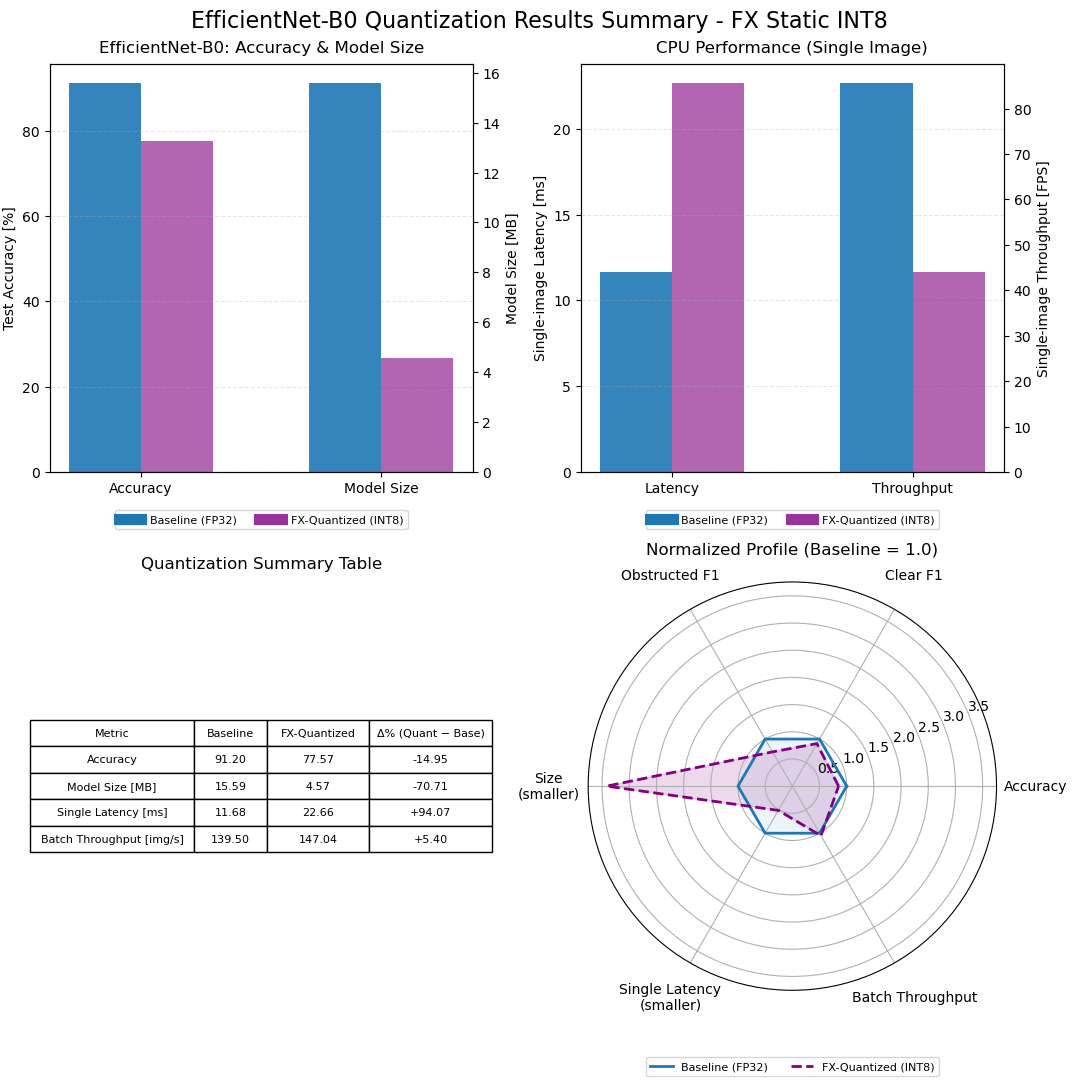

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Pull numbers (EfficientNet-B0)
# -----------------------------
acc_base   = float(acc_effb0)
acc_quant  = float(acc_effb0_quant_fx)

f1_clear_base  = float(metrics_effb0["clear"][2])
f1_clear_quant = float(metrics_effb0_quant_fx["clear"][2])
f1_obst_base   = float(metrics_effb0["obstructed"][2])
f1_obst_quant  = float(metrics_effb0_quant_fx["obstructed"][2])

size_base  = float(baseline_size_mb)
size_quant = float(quant_fx_size_mb)

single_lat_base  = float(effb0_latency_stats["single_mean_ms"])
single_lat_quant = float(quantized_latency_stats["single_mean_ms"])
single_fps_base  = float(effb0_latency_stats["single_fps"])
single_fps_quant = float(quantized_latency_stats["single_fps"])

batch_lat_base   = float(effb0_latency_stats["batch_mean_ms"])
batch_lat_quant  = float(quantized_latency_stats["batch_mean_ms"])
batch_fps_base   = float(effb0_latency_stats["batch_fps"])
batch_fps_quant  = float(quantized_latency_stats["batch_fps"])

def pct_change(new, old):
    return (new - old) / old * 100.0

# -----------------------------
# Figure & axes
# -----------------------------
fig = plt.figure(figsize=(11, 11))
fig.suptitle("EfficientNet-B0 Quantization Results Summary - FX Static INT8",
             fontsize=16, y=0.98)

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4, projection='polar')

for ax in [ax1, ax2, ax3]:
    try:
        ax.set_box_aspect(1)
    except Exception:
        pass

baseline_color = "tab:blue"
quant_color    = "purple"
width = 0.3

# =======================================================
# Subplot 1 – Accuracy & Model Size
# =======================================================
metrics1 = ["Accuracy", "Model Size"]
x = np.arange(len(metrics1))

ax1_left = ax1
ax1_right = ax1_left.twinx()

# Accuracy (left axis)
acc_x = x[0]
ax1_left.bar(acc_x - width/2,
             acc_base * 100,
             width,
             color=baseline_color,
             alpha=0.9)
ax1_left.bar(acc_x + width/2,
             acc_quant * 100,
             width,
             color=quant_color,
             alpha=0.6)

# Model size (right axis)
size_x = x[1]
ax1_right.bar(size_x - width/2,
              size_base,
              width,
              color=baseline_color,
              alpha=0.9)
ax1_right.bar(size_x + width/2,
              size_quant,
              width,
              color=quant_color,
              alpha=0.6)

ax1_left.set_xticks(x)
ax1_left.set_xticklabels(metrics1)
ax1_left.set_ylabel("Test Accuracy [%]")
ax1_right.set_ylabel("Model Size [MB]")
ax1_left.set_title("EfficientNet-B0: Accuracy & Model Size", pad=8)
ax1_left.grid(axis="y", linestyle="--", alpha=0.3)

handles1 = [
    plt.Line2D([0], [0], color=baseline_color, lw=8, label="Baseline (FP32)"),
    plt.Line2D([0], [0], color=quant_color,   lw=8, alpha=0.8,
               label="FX-Quantized (INT8)"),
]
ax1_left.legend(handles=handles1,
                loc="upper center",
                bbox_to_anchor=(0.5, -0.08),
                ncol=2,
                fontsize=8)

# =======================================================
# Subplot 2 – Latency & Throughput (single-image)
# =======================================================
metrics2 = ["Latency", "Throughput"]
x2 = np.arange(len(metrics2))

ax2_left = ax2
ax2_right = ax2_left.twinx()

# Latency (left axis)
lat_x = x2[0]
ax2_left.bar(lat_x - width/2,
             single_lat_base,
             width,
             color=baseline_color,
             alpha=0.9)
ax2_left.bar(lat_x + width/2,
             single_lat_quant,
             width,
             color=quant_color,
             alpha=0.6)

# Throughput (right axis)
thr_x = x2[1]
ax2_right.bar(thr_x - width/2,
              single_fps_base,
              width,
              color=baseline_color,
              alpha=0.9)
ax2_right.bar(thr_x + width/2,
              single_fps_quant,
              width,
              color=quant_color,
              alpha=0.6)

ax2_left.set_xticks(x2)
ax2_left.set_xticklabels(metrics2)
ax2_left.set_ylabel("Single-image Latency [ms]")
ax2_right.set_ylabel("Single-image Throughput [FPS]")
ax2_left.set_title("CPU Performance (Single Image)", pad=8)
ax2_left.grid(axis="y", linestyle="--", alpha=0.3)

handles2 = [
    plt.Line2D([0], [0], color=baseline_color, lw=8, label="Baseline (FP32)"),
    plt.Line2D([0], [0], color=quant_color,   lw=8, alpha=0.8,
               label="FX-Quantized (INT8)"),
]
ax2_left.legend(handles=handles2,
                loc="upper center",
                bbox_to_anchor=(0.5, -0.08),
                ncol=2,
                fontsize=8)

# =======================================================
# Subplot 3 – Summary table
# =======================================================
ax3.axis("off")

table_data = [
    ["Accuracy",
     f"{acc_base*100:.2f}", f"{acc_quant*100:.2f}",
     f"{pct_change(acc_quant, acc_base):+.2f}"],
    ["Model Size [MB]",
     f"{size_base:.2f}", f"{size_quant:.2f}",
     f"{pct_change(size_quant, size_base):+.2f}"],
    ["Single Latency [ms]",
        f"{single_lat_base:.2f}", f"{single_lat_quant:.2f}",
        f"{pct_change(single_lat_quant, single_lat_base):+.2f}"],
    ["Batch Throughput [img/s]",
        f"{batch_fps_base:.2f}", f"{batch_fps_quant:.2f}",
        f"{pct_change(batch_fps_quant, batch_fps_base):+.2f}"],
]

col_labels = ["Metric", "Baseline", "FX-Quantized", "Δ% (Quant − Base)"]
col_widths = [0.40, 0.18, 0.25, 0.30]

table = ax3.table(cellText=table_data,
                  colLabels=col_labels,
                  loc="center",
                  cellLoc="center",
                  colWidths=col_widths)

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.0, 1.5)
ax3.set_title("Quantization Summary Table", pad=10)

# =======================================================
# Subplot 4 – Radar / Spider
# =======================================================
radar_labels = [
    "Accuracy",
    "Clear F1",
    "Obstructed F1",
    "Size\n(smaller)",
    "Single Latency\n(smaller)",
    "Batch Throughput"
]

baseline_radar = np.ones(len(radar_labels))
quant_radar = np.array([
    acc_quant / acc_base,
    f1_clear_quant / f1_clear_base,
    f1_obst_quant / f1_obst_base,
    size_base / size_quant,
    single_lat_base / single_lat_quant,
    batch_fps_quant / batch_fps_base,
])

angles = np.linspace(0, 2*np.pi, len(radar_labels), endpoint=False)
angles = np.concatenate([angles, angles[:1]])
baseline_plot = np.concatenate([baseline_radar, baseline_radar[:1]])
quant_plot    = np.concatenate([quant_radar,   quant_radar[:1]])

ax4.plot(angles, baseline_plot, linewidth=2, color=baseline_color,
         label="Baseline (FP32)")
ax4.fill(angles, baseline_plot, alpha=0.08, color=baseline_color)

ax4.plot(angles, quant_plot, linewidth=2, linestyle="--", color=quant_color,
         label="FX-Quantized (INT8)")
ax4.fill(angles, quant_plot, alpha=0.15, color=quant_color)

ax4.set_xticks(angles[:-1])
ax4.set_xticklabels(radar_labels)
ax4.set_ylim(0, max(1.2, quant_radar.max() * 1.1))
ax4.set_title("Normalized Profile (Baseline = 1.0)", pad=20)
ax4.tick_params(axis='x', pad=18)
ax4.set_aspect('equal', adjustable='box')

ax4.legend(loc="upper center",
           bbox_to_anchor=(0.5, -0.15),
           ncol=2,
           fontsize=8)

plt.tight_layout()
plt.show()
